In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from global_import import *
from valuation.val import perform_valuation

In [2]:
data = pd.read_csv(f'{DATA_FOLDER}/lagged_comp-fundr-ibes_for_val_1976-2019.csv', index_col = 0)
crsp = pd.read_csv(f'{DATA_FOLDER}/crsp_1959-2019.csv', index_col=0)
beta = pd.read_csv(f'{DATA_FOLDER}/capm_beta_weekly_1-3y_1959-2019.csv', index_col=0)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.drop_duplicates(subset=['jdate', 'permno'])

<AxesSubplot:>

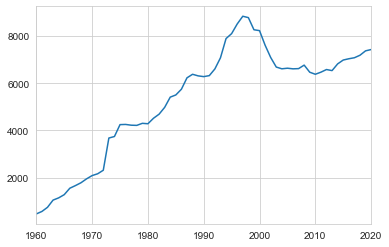

In [4]:
data['year'].value_counts().sort_index().plot()

In [77]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import datetime
from copy import deepcopy

mdfs={}
regr_dict_agg={}
pred_years = [1]

for year in range(1982, 1986): #1960-1999
    regr_dict = {}
    for pred_yr in pred_years:
        tr = data.loc[(year <= data['year']) & (data['year'] <= year+19)]
        tryr = tr.dropna(subset = [f'epspx_{pred_yr}'])
        X_tr = tryr.drop(['ticker', 'exchcd', 'permno','jdate','year',
#                           'epspx_0', 'epspx_-1', 'epspx_-2', 'epspx_-3','epspx_-4','epspx_-5', 'niepspx',
#                           'pi', 'csho',
                          'epspx_1', 'epspx_2', 'epspx_3','epspx_4','epspx_5'], axis = 1)
        X_tr = X_tr.fillna(0).astype(float)
        y_tr = tryr[f'epspx_{pred_yr}'] 
        y_tr = y_tr.astype(float)
        rf_yr = GradientBoostingRegressor(random_state=0, n_estimators=50, max_depth=3, loss='huber')
        rf_yr.fit(X_tr, y_tr)
        regr_dict[pred_yr] = deepcopy(rf_yr)
        print(datetime.now(),year, pred_yr, 'IS R2', r2_score(y_tr, rf_yr.predict(X_tr)), X_tr.shape)
        
    ts = data.loc[(year+20 == data['year'])]
    X_ts = ts.drop(['ticker', 'exchcd', 'permno','jdate','year',
#                     'epspx_0', 'epspx_-1', 'epspx_-2', 'epspx_-3','epspx_-4','epspx_-5', 'niepspx',
#                     'pi', 
                    'epspx_1', 'epspx_2', 'epspx_3','epspx_4','epspx_5'], axis = 1)
    X_ts = X_ts.fillna(0).astype(float)
    
    y_pred_dict = {}
    for pred_yr in pred_years:
        y_ts = ts[f'epspx_{pred_yr}'].fillna(0).astype(float)
        y_pred_dict[pred_yr] = regr_dict[pred_yr].predict(X_ts)
        try:
            print(datetime.now(), year+20, pred_yr, 'OOS R2', \
                 r2_score(y_ts[ts[f'epspx_{pred_yr}']>=1], 
                          y_pred_dict[pred_yr][ts[f'epspx_{pred_yr}']>=1]),
                 y_ts.shape, y_ts[ts[f'epspx_{pred_yr}']>=1].shape)
        except:
            print('no')
        
    mdf_rf = ts[['ticker', 'permno', 'exchcd', 'year', 'jdate', 'be']].copy()
    for pred_yr in pred_years:
        mdf_rf[f'epspx_{pred_yr}'] =  y_pred_dict[pred_yr]
        
    mdfs[year+20] = deepcopy(mdf_rf)
    
    regr_dict_agg[year] = regr_dict

KeyboardInterrupt: 

['lt' 'ceq' 'capx' 'che' 'csho' 'dp' 'be' 'inv_turn' 'ebitda' 'dpc' 'revt'
 'epspx_0' 'nopi' 'ppegt' 'niadj' 'ppent' 'wcap' 'pi' 'chech' 'aqc']


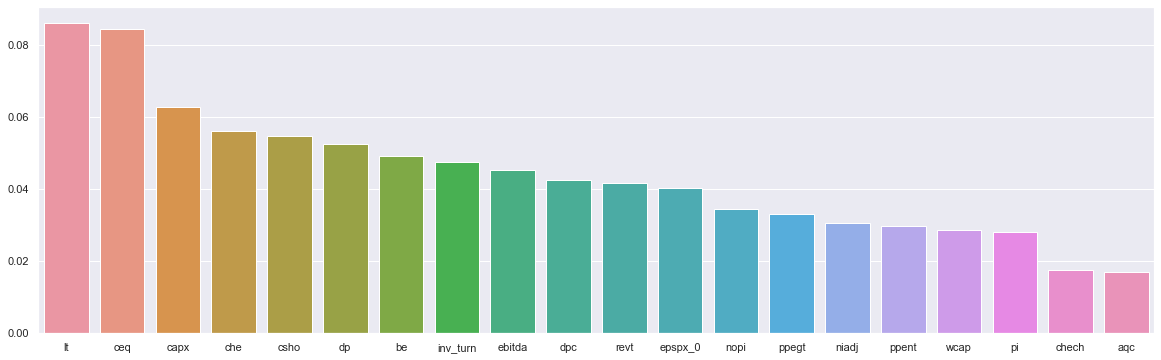

In [76]:
rf1 = regr_dict_agg[1984][1]
numf = 20
print(np.asarray(list(X_ts.keys()))[(np.abs(rf1.feature_importances_[:]).argsort()[-numf:][::-1])])
sns.set(rc={'figure.figsize':(numf,6)})
ax1 = sns.barplot(x=np.asarray(list(X_ts.keys()))[rf1.feature_importances_[:].argsort()[-numf:][::-1]], 
                  y=(rf1.feature_importances_[:][rf1.feature_importances_[:].argsort()[-numf:][::-1]]))

In [72]:
tryr[['ticker', 'jdate', 'med_eps_1', 'epspx_1', 'epspx_0']].dropna().head(40)

,ticker,jdate,med_eps_1,epspx_1,epspx_0
117,BTFG,2004-06-30,0.97,0.966962,0.72
120,BTFG,2003-06-30,0.88,0.898495,0.85
270,GACO,1987-06-30,1.38,1.300883,1.10
319,CBOT,1994-06-30,0.44,0.349951,-1.13
320,CBOT,1993-06-30,0.29,-1.254053,-0.29
321,CBOT,1992-06-30,0.26,-0.291495,0.35
322,CBOT,1991-06-30,0.29,0.378404,0.22
329,ATCE,1996-06-30,1.22,0.733771,0.57
338,DPAC,2004-06-30,-0.29,-0.668019,0.12
339,DPAC,2003-06-30,-0.06,0.120011,0.09


In [6]:
mdf_rf = pd.concat(mdfs.values())

In [7]:
mdf_rf = mdf_rf.sort_values(by=['permno', 'jdate'])

In [8]:
mdf_rf[mdf_rf.ticker=='TSLA']

,ticker,permno,exchcd,year,jdate,be,ni_1,ni_2,ni_3,ni_4,ni_5,ni_6,ni_7,ni_8,ni_9,ni_10
692395,TSLA,93436,3.0,2010,2010-06-30,NaN,28.711807,30.345887,25.750219,24.571279,19.302648,19.302648,19.302648,19.302648,19.302648,19.302648
692392,TSLA,93436,3.0,2011,2011-06-30,207.048,30.619149,30.502099,29.110508,26.161481,22.137074,22.137074,22.137074,22.137074,22.137074,22.137074
692389,TSLA,93436,3.0,2012,2012-06-30,224.045,35.225982,29.878035,29.993716,29.065579,25.817069,25.817069,25.817069,25.817069,25.817069,25.817069
692386,TSLA,93436,3.0,2013,2013-06-30,124.700,33.954056,32.119949,29.237387,27.517502,25.099676,25.099676,25.099676,25.099676,25.099676,25.099676
692383,TSLA,93436,3.0,2014,2014-06-30,673.941,32.431216,31.814242,30.027433,-1070.609161,28.038643,28.038643,28.038643,28.038643,28.038643,28.038643
692380,TSLA,93436,3.0,2015,2015-06-30,969.906,33.855384,27.522670,29.686266,-10.771434,26.628550,26.628550,26.628550,26.628550,26.628550,26.628550
692377,TSLA,93436,3.0,2016,2016-06-30,1130.989,37.343768,28.053482,29.673946,32.285435,33.019387,33.019387,33.019387,33.019387,33.019387,33.019387
692374,TSLA,93436,3.0,2017,2017-06-30,4761.695,31.924925,27.761088,31.357752,38.919601,204.684297,204.684297,204.684297,204.684297,204.684297,204.684297
692371,TSLA,93436,3.0,2018,2018-06-30,4237.312,28.319278,30.088603,34.904791,35.322911,279.215216,279.215216,279.215216,279.215216,279.215216,279.215216


In [9]:
comp = mdf_rf
comp['jdate'] = pd.to_datetime(comp['jdate'])
comp.permno = comp.permno.astype(int)

beta['date']=pd.to_datetime(beta['DATE'].astype(str))
beta['jdate']=beta['date']+MonthEnd(0)
beta['permno'] = beta.index
beta = beta.drop_duplicates(subset=['permno', 'jdate'])

In [10]:
FF = pd.read_csv(f'{PROJECT_FOLDER}/lookup_tables/FF3.csv')
FF['date'] = FF['Unnamed: 0']
FF['date'] = pd.to_datetime(FF['date'].astype(str), format='%Y%m%d')
FF['jdate'] = FF['date']+MonthEnd(0)
FF = FF[['jdate', 'date', 'RF']]
FF['RF'] = (1+FF['RF']/100).pow(365)-1

beta = beta.merge(FF[['jdate', 'RF']],  on=['jdate'])
beta = beta.drop_duplicates(subset=['permno', 'jdate'])

In [11]:
comp.sort_values(['permno','jdate'], ascending = [True,True], inplace=True)
crsp['logret'] = np.log(1+crsp['retadj'])
crsp['termlogret'] = crsp.groupby('permno')['logret'].transform('sum') - crsp.groupby('permno')['logret'].transform('cumsum') + np.log(1-0.35) 
crsp['termcumret'] = np.exp(crsp['termlogret'])-1
crsp1 = crsp.copy()

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [12]:
for x in ['logret_3', 'logret_6', 'logret_12', 'logret_24', 
      'logret_36', 'logret_48', 'logret_60']:
    crsp1.loc[crsp1[x].isnull(), x] = crsp1['termlogret']


for x in ['cumret_3', 'cumret_6', 'cumret_12', 'cumret_24', 
      'cumret_36', 'cumret_48', 'cumret_60']:
    crsp1.loc[crsp1[x].isnull(), x] = crsp1['termcumret']

In [13]:
valdf = comp.merge(beta, on=['jdate', 'permno'])
valdf = perform_valuation(valdf, n=5, rp=0.07, tg=0.05)
valdf = valdf[['permno', 'year', 'PV', 'be']]
valdf.year = valdf.year + 1
val_crsp_mdf = valdf.merge(crsp1, on=['year', 'permno'])
val_crsp_mdf['vt'] = val_crsp_mdf['PV']*1000
val_crsp_mdf['be'] = val_crsp_mdf['be']*1000

In [22]:
val_df1 = val_crsp_mdf[['permno', 'ticker',  'exchcd', 'year', 'jdate', 'exchcd',
                        'PV', 'vt','me', 'be', 'prc',
                        'logret_3', 'logret_6', 'logret_24', 'cumret_3', 'cumret_6', 'cumret_24',
                        'logret_12', 'logret_36', 'logret_48', 'logret_60', 
                        'cumret_12', 'cumret_36', 'cumret_48', 'cumret_60',]]
val_df1.sort_values(['permno','jdate'], ascending = [True,False], inplace=True)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
val_df2 = val_df1.copy()
for m in [3, 6, 12, 24, 36, 48, 60]:
    val_df2[f'vt+{m}'] = val_df1.groupby('permno')['vt'].shift(m)
    val_df2[f'me+{m}'] = val_df1.groupby('permno')['me'].shift(m)
    val_df2[f'be+{m}'] = val_df1.groupby('permno')['be'].shift(m)

In [24]:
val_df3 = val_df2.copy()
for m in [3, 6, 12, 24, 36, 48, 60]:
    val_df3['vt'] = np.log(val_df2.vt)
    val_df3[f'vt+{m}'] = np.log(val_df2[f'vt+{m}'].astype(float))
    val_df3['me'] = np.log(val_df2['me'].astype(float))
    val_df3[f'me+{m}'] = np.log(val_df2[f'me+{m}'].astype(float))
    val_df3[f'r_t+{m}'] = val_df3[f'logret_{m}']
    val_df3[f'r*_t+{m}'] = val_df3[f'vt+{m}'] -  val_df3[f'vt']
    val_df3[f'r_unchg+{m}'] = - (1-0.975) * (val_df3['me'] -  val_df3['vt'])
    val_df3[f'r_chg+{m}'] = 0.975 * ( (val_df3[f'me+{m}'] -  val_df3[f'vt+{m}']) - ((val_df3[f'me'] -  val_df3['vt'])) )
    

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [25]:
val_df3 = val_df3[(val_df3.year >=1980) & (val_df3.year<=2020)]
val_df3 = val_df3.drop_duplicates(subset=['permno', 'jdate'])

In [26]:
val_df3['misp'] = val_df3['me'] - val_df3['vt']
# val_df3 = val_df3.dropna(subset=['misp', 'r_t+60'])
val_df3 = val_df3.replace([np.inf, -np.inf], np.nan)

In [27]:
val_df3[(val_df3.ticker=='WMT') ]

,permno,ticker,exchcd,year,jdate,exchcd,PV,vt,me,be,prc,logret_3,logret_6,logret_24,cumret_3,cumret_6,cumret_24,logret_12,logret_36,logret_48,logret_60,cumret_12,cumret_36,cumret_48,cumret_60,vt+3,me+3,be+3,vt+6,me+6,be+6,vt+12,me+12,be+12,vt+24,me+24,be+24,vt+36,me+36,be+36,vt+48,me+48,be+48,vt+60,me+60,be+60,r_t+3,r*_t+3,r_unchg+3,r_chg+3,r_t+6,r*_t+6,r_unchg+6,r_chg+6,r_t+12,r*_t+12,r_unchg+12,r_chg+12,r_t+24,r*_t+24,r_unchg+24,r_chg+24,r_t+36,r*_t+36,r_unchg+36,r_chg+36,r_t+48,r*_t+48,r_unchg+48,r_chg+48,r_t+60,r*_t+60,r_unchg+60,r_chg+60,misp
733803,55976,WMT,1,2019,2019-12-31,1,1.180175e+06,20.888929,19.636097,82131000.0,118.839996,-0.430783,-0.430783,-0.430783,-0.350000,-0.350000,-0.350000,-0.430783,-0.430783,-0.430783,-0.430783,-0.350000,-0.350000,-0.350000,-0.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-1.252831
733802,55976,WMT,1,2019,2019-11-30,1,1.180175e+06,20.888929,19.640701,82131000.0,119.089996,-0.428435,-0.428435,-0.428435,-0.348472,-0.348472,-0.348472,-0.428435,-0.428435,-0.428435,-0.428435,-0.348472,-0.348472,-0.348472,-0.348472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-1.248227
733801,55976,WMT,1,2019,2019-10-31,1,1.180175e+06,20.888929,19.625216,82131000.0,117.260002,-0.412949,-0.412949,-0.412949,-0.338304,-0.338304,-0.338304,-0.412949,-0.412949,-0.412949,-0.412949,-0.338304,-0.338304,-0.338304,-0.338304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-1.263713
733800,55976,WMT,1,2019,2019-09-30,1,1.180175e+06,20.888929,19.637253,82131000.0,118.680000,0.005797,-0.424986,-0.424986,0.005814,-0.346221,-0.346221,-0.424986,-0.424986,-0.424986,-0.424986,-0.346221,-0.346221,-0.346221,-0.346221,20.888929,19.636097,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005797,0.000000,0.031292,-0.001126,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-1.251676
733799,55976,WMT,1,2019,2019-08-31,1,1.180175e+06,20.888929,19.602962,82131000.0,114.260002,0.041403,-0.387032,-0.387032,0.042272,-0.320930,-0.320930,-0.387032,-0.387032,-0.387032,-0.387032,-0.320930,-0.320930,-0.320930,-0.320930,20.888929,19.640701,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041403,0.000000,0.032149,0.036796,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-1.285967
733798,55976,WMT,1,2019,2019-07-31,1,1.180175e+06,20.888929,19.568414,82131000.0,110.379997,0.065093,-0.347856,-0.347856,0.067258,-0.293800,-0.293800,-0.347856,-0.347856,-0.347856,-0.347856,-0.293800,-0.293800,-0.293800,-0.293800,20.888929,19.625216,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065093,0.000000,0.033013,0.055382,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-1.320515
733797,55976,WMT,1,2019,2019-06-30,1,1.180175e+06,20.888929,19.569410,82131000.0,110.489998,0.076134,0.081931,-0.348852,0.079107,0.085381,-0.294503,-0.348852,-0.348852,-0.348852,-0.348852,-0.294503,-0.294503,-0.294503,-0.294503,20.888929,19.637253,82131000.0,20.888929,19.63609

In [31]:
val_df3[val_df3.PV>0].shape

(1591830, 75)

In [28]:
val_df3 = val_df3.replace([np.inf, -np.inf], np.nan)
val_df3.to_csv(f'{DATA_FOLDER}/decomp_dcf5y_RF_rolling_1980_2019.csv')

In [29]:
val_df3.describe()

,permno,exchcd,year,exchcd,PV,vt,me,be,prc,logret_3,logret_6,logret_24,cumret_3,cumret_6,cumret_24,logret_12,logret_36,logret_48,logret_60,cumret_12,cumret_36,cumret_48,cumret_60,vt+3,me+3,be+3,vt+6,me+6,be+6,vt+12,me+12,be+12,vt+24,me+24,be+24,vt+36,me+36,be+36,vt+48,me+48,be+48,vt+60,me+60,be+60,r_t+3,r*_t+3,r_unchg+3,r_chg+3,r_t+6,r*_t+6,r_unchg+6,r_chg+6,r_t+12,r*_t+12,r_unchg+12,r_chg+12,r_t+24,r*_t+24,r_unchg+24,r_chg+24,r_t+36,r*_t+36,r_unchg+36,r_chg+36,r_t+48,r*_t+48,r_unchg+48,r_chg+48,r_t+60,r*_t+60,r_unchg+60,r_chg+60,misp
count,1.800572e+06,1.800572e+06,1.800572e+06,1.800572e+06,1.796070e+06,1.591830e+06,1.799441e+06,1.613882e+06,1.799441e+06,1.800548e+06,1.800534e+06,1.800466e+06,1.800566e+06,1.800566e+06,1.800566e+06,1.800510e+06,1.800430e+06,1.800394e+06,1.800368e+06,1.800566e+06,1.800566e+06,1.800566e+06,1.800566e+06,1.551639e+06,1.755786e+06,1.575507e+06,1.512284e+06,1.713003e+06,1.537932e+06,1.436074e+06,1.630162e+06,1.465250e+06,1.295065e+06,1.476899e+06,1.330479e+06,1.166083e+06,1.337391e+06,1.207239e+06,1.050179e+06,1.211101e+06,1.094923e+06,946555.000000,1.097209e+06,9.932620e+05,1.800548e+06,1.540717e+06,1.591244e+06,1.539882e+06,1.800534e+06,1.490659e+06,1.591244e+06,1.489882e+06,1.800510e+06,1.393850e+06,1.591244e+06,1.393206e+06,1.800466e+06,1.233272e+06,1.591244e+06,1.232718e+06,1.800430e+06,1.097718e+06,1.591244e+06,1.097192e+06,1.800394e+06,986855.000000,1.591244e+06,986368.000000,1.800368e+06,897343.000000,1.591244e+06,896923.000000,1.591244e+06
mean,5.857090e+04,2.039237e+00,2.000843e+03,2.039237e+00,4.827308e+04,1.299058e+01,1.236006e+01,1.752216e+06,3.228738e+01,-5.852499e-03,-1.191804e-02,-3.460469e-02,2.652256e-02,5.268916e-02,2.128236e-01,-2.038228e-02,-5.228012e-02,-6.496492e-02,-7.628381e-02,1.097207e-01,3.008009e-01,3.963367e-01,4.969660e-01,1.301334e+01,1.238433e+01,1.780574e+06,1.303679e+01,1.240813e+01,1.809514e+06,1.308566e+01,1.245858e+01,1.869008e+06,1.319964e+01,1.255968e+01,1.988477e+06,1.330587e+01,1.265250e+01,2.112393e+06,1.340888e+01,1.274686e+01,2.243333e+06,13.518035,1.283696e+01,2.381796e+06,-5.852499e-03,2.080467e-02,1.552716e-02,-1.296268e-02,-1.191804e-02,4.268956e-02,1.552716e-02,-2.652612e-02,-2.038228e-02,8.982144e-02,1.552716e-02,-4.939772e-02,-3.460469e-02,2.027442e-01,1.552716e-02,-9.532286e-02,-5.228012e-02,3.190333e-01,1.552716e-02,-1.434996e-01,-6.496492e-02,0.433140,1.552716e-02,-0.180523,-7.628381e-02,0.552892,1.552716e-02,-0.222072,-6.210864e-01
std,2.637426e+04,9.434354e-01,1.078938e+01,9.434354e-01,1.440595e+07,2.034076e+00,2.270722e+00,8.620251e+06,8.522052e+02,2.584475e-01,3.694166e-01,7.515871e-01,2.855282e-01,4.316977e-01,1.227976e+00,5.302124e-01,9.097679e-01,1.039295e+00,1.147373e+00,8.491562e-01,1.583381e+00,2.064557e+00,2.904363e+00,2.038553e+00,2.270660e+00,8.698087e+06,2.042835e+00,2.271012e+00,8.776302e+06,2.050782e+00,2.269742e+00,8.932918e+06,2.049778e+00,2.267238e+00,9.236273e+06,2.054277e+00,2.270922e+00,9.527619e+06,2.061097e+00,2.274477e+00,9.808256e+06,2.060837,2.279403e+00,1.013522e+07,2.584475e-01,3.183724e-01,4.179739e-02,4.091976e-01,3.694166e-01,4.544651e-01,4.179739e-02,5.803193e-01,5.302124e-01,6.556528e-01,4.179739e-02,8.220245e-01,7.515871e-01,8.813811e-01,4.179739e-02,1.095265e+00,9.097679e-01,1.010065e+00,4.179739e-02,1.228838e+00,1.039295e+00,1.086478,4.179739e-02,1.298333,1.147373e+00,1.116667,4.179739e-02,1.336246,1.671896e+00
min,1.000100e+04,1.000000e+00,1.981000e+03,1.000000e+00,-7.172960e+07,6.827981e+00,1.313388e+00,1.000000e+00,1.050000e-02,-9.478570e+00,-1.091677e+01,-1.515275e+01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.244822e+01,-1.684451e+01,-1.874448e+01,-1.874448e+01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,7.102868e+00,1.313388e+00,1.000000e+00,7.102868e+00,1.313388e+00,1.000000e+00,7.102868,1.313388e+00,1.000000e+00,-9.478570e+00,-1.46264